# 16. 프로젝트 : mini BERT 만들기

## 노드 정리
### BERT(Bidirectional Encoder Representations from Transformers)
2018년에 등장한 BERT는 양방향(bi-direction)으로 input을 보며, 트랜스포머의 encoder만 사용한다. 다음 단어를 예측하는 GPT와 달리 문장 내 [빈칸]을 맞추는 모델이다. 

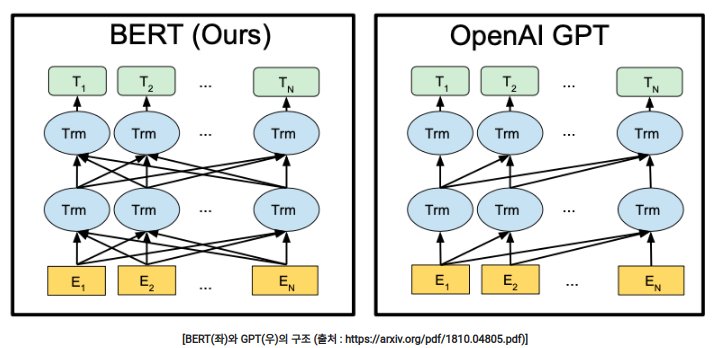

#### 1. BERT의 구조
트랜스포머의 구조를 이용한 모델이므로 트랜스포머와의 차이점을 위주로 본다.

##### 1. Transformer Encoder Block

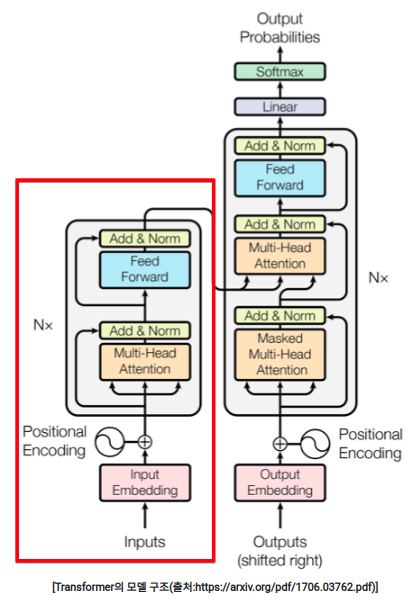

그림과 같이 Transformer의 Encoder만 사용한다. 그러나 트랜스포머와는 달리 3개의 임베딩을 가지고 있다.

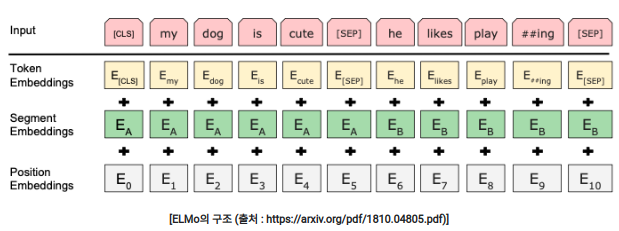

- Token Embedding      
Wordpiece를 이용해 3만개의 vocabulary를 학습하고, 학습한 Wordpiece model을 이용해 token을 임베딩한다. 

- Segment Embedding       
__두 가지 sentence__ (텍스트 덩어리의 의미)를 입력으로 받기 때문에 2가지 sentence를 구분해야 한다. 모델의 입장에서 이어진 텍스트들의 덩어리를 segment embedding이 나누어 준다. 그림에서 ```[SEP]``` 토큰으로 구분된 두 sentence에서 앞부분은 A, 뒷부분은 B로 나누어 임베딩한다. 

- Position Embedding         
segment embedding에서 두 sentence를 나누었지만 sentence 안에서의 순서를 모르기 때문에 position embedding을 통해 __문장 내에서 절대적인 위치(순서)__ 를 알려준다. __학습__ 을 통해 position 정보를 습득한다. 

위의 3 가지 임베딩을 모두 합산해 BERT의 임베딩이 완성된다. 이후 layer normalization과 dropout을 해준다.

- BERT의 토큰 

    - ```[CLS]``` : sentence의 시작을 알리는 토큰       
    - ```[SEP]``` : sentence의 종결을 알리는 토큰, sentence를 구분하는 데에 사용하기도 함        
    - ```[MASK]```: 마스크 토큰         
    - ```[PAD]``` : 배치 데이터의 길이를 맞춰주기 위한 토큰
    
#### 2. Activation Function(활성화 함수) : GELU
__Feedforward Networks__ 에서 BERT는 ReLU대신 __GELU__ 를 사용한다. GELU는 음수에서도 완만한 곡선을 그리기 때문에 미분이 가능하다. GELU를 사용하면 성능이 더욱 좋아지기 때문에 BERT의 저자들은 GELU를 사용했다 한다.

### 2. BERT의 학습
BERT는 양방향(Bi-direction)을 강조한 모델이다. 

#### 1) Masked LM(MLM)
BERT는 마스크된 토큰(```[MASK]```)만 맞추면 되는 Masked LM(MLM)을 제안했다. 따라서 input sequence의 순서에 상관 없이 전체 문장을 모두 볼 수 있다. 

MLM을 위해서 BERT는 학습 데이터의 전체에서 15%를 ```[MASK]``` 토큰으로 랜덤하게 바꾼다. 또한 15%에 해당하는 모든 토큰들 중 80%는 ```[MASK]```토큰, 10%는 무작위로 랜덤한 토큰으로, 나머지 10%는 원래의 토큰을 그대로 사용한다. 

pretrain을 끝낸 모델을 finetuning할 때에는 input에 ```[MASK]```토큰이 등장하지 않기 때문에 ```[MASK]```토큰의 존재 유무가 모델 성능에 영향을 미치게 될 수 있으므로 ```[MASK]```토큰이 아닌 것들도 예측을 하도록 학습하여 문장 자체에 대한 전반적인 이해(문맥에 대한 이해)를 할 수 있도록 해주었다.

2) Next Sentence Prediction (NSP)

BERT는 마스크된 토큰을 맞추는 것과 동시에 또 다른 task인 Next Sentence Prediction (NSP, 다음 문장인지 확인하기)를 함께 학습한다. 

한 행을 하나의 sentence라고 가정할 때 두 sentence가 연속해서 오는지 여부를 학습한다. NSP를 위해 BERT의 학습 데이터는 1건당 2개의 문장으로 구성하고, 50%의 확률로 TRUE와 FALSE를 부여한다.

- max_num_tokens 정의    

task가 너무 쉬워지는 것을 방지하기 위해 max_num_tokens를 정의한 후, 데이터의 90%는 max_num_tokens = max_sequence_length, 10%의 데이터는 max_num_tokens < max_sequence_length이 되도록 랜덤으로 정한다. 이후 두 개의 sentence의 단어 총수가 max_num_tokens보다 작아질 때까지 두 sentence 중 단어 수가 많은 쪽의 문장 맨 앞 또는 맨 뒤 단어를 하나씩 제거한다. 문장 맨 앞의 단어를 선택할지, 맨 뒤의 단어를 선택할지는 50%의 확률로 정한다. 

이렇게 NSP를 학습하면 문장과 문장 사이의 관계를 학습할 수 있다. 문장의 길이를 임의로 조정하면서 짧은 문장에 대해서도 성능이 크게 떨어지지 않게 되며, 문장의 단어들을 랜덤하게 삭제하는 과정을 통해 문장의 일부 단어들이 없어져도 큰 영향을 받지 않는다. 

MLM과 NSP는 동시에 학습된다. 따라서 실제 BERT의 학습 데이터셋은 아래와 같은 구조일 것이다. (편의를 위해 토큰을 띄어쓰기 단위로 나누었다.)

>```[CLS]```여름의 마지막 ```[MASK]``` 누가 제일 늦게 ```[MASK]``` 나왔나 ```[SEP]``` 그 사람이 바다의 ```[MASK]``` 닫지 않고 돌아가```[SEP]``` → Label : TRUE(IsNext)
>
>```[CLS]```여름의 ```[MASK]``` 해수욕 누가 제일 늦게 바다에서 나왔나 ```[SEP]``` 한강에서 ```[MASK]``` 아이스 아메리카노를 마시고 싶다```[SEP]``` → Label : FALSE(NotNext)

### 3. Fine-tuning Task
BERT는 한 모델이 다양한 task를 수행하므로 input transformation을 이용한다.

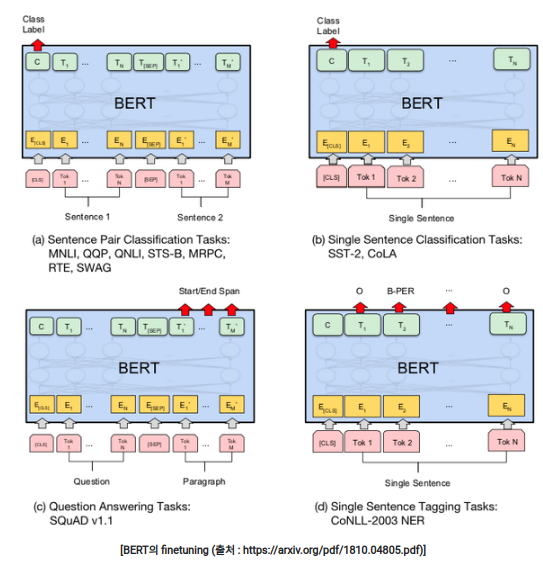

classification 같은 경우는 ```[CLS]```토큰을, QA와 같이 문장이나 단어들이 나와야 하는 경우에는 토큰들의 벡터를 output layer에 넣어 output을 산출한다.

## 16. 프로젝트 : mini BERT 만들기
지금까지 BERT 모델을 pretrain하는 험난한 여정을 잘 따라오셨나요?

이번 프로젝트의 과제는 간단합니다.

vocab size를 8000으로 줄이고, 전체 파라미터 사이즈가 1M 정도가 되는 아주 작은 mini BERT 모델을 만들어 10Epoch까지 학습시킨 모델을 만들어 보는 것입니다.

그래서 학습 진행 결과를 시각화하여 제출해 주세요. 수고 많으셨습니다.

### 1. Tokenizer 준비       
SentencePiece 기반의 토크나이저를 준비한다.

In [3]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import sentencepiece as spm
from tqdm.notebook import tqdm

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# tf version 및 gpu 확인
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


준비해 둔 한글 나무위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 생성한다.

BERT에 사용되는 [MASK], [SEP], [CLS] 등의 주요 특수문자가 vocab에 포함되어야 한다. (약 10분 정도가 소요)

In [4]:
import sentencepiece as spm
import os
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰

print("완료=3")   # 완료메시지가 출력될 때까지 아무 출력내용이 없더라도 기다려 주세요.

완료=3


In [5]:
!ls -l ko_8000*

-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44 350352  5월 14 20:19 ko_8000.model
-rw-rw-r-- 1 aiffel-dj44 aiffel-dj44  95482  5월 14 20:19 ko_8000.vocab


sentencepiece 모델 학습이 끝난 후 생성된 ko_8000.model, ko_8000.vocab 두 파일은 현재의 노트북이 위치한 곳에 생성되었으므로 이 두 파일을 ~/aiffel/bert_pretrain/models 아래로 이동시킨 후 진행한다. 

In [6]:
import sentencepiece as spm
import os

data_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_pretrain/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_8000.model")

True

토크나이저가 잘 만들어졌는지 확인해본다. 

In [7]:
# 특수 token 7개를 제외한 나머지 tokens 들
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))
print(vocab_list[:50])

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동']


In [8]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


### 2. 데이터 전처리 (1) MASK 생성

BERT의 Masked Language Model은 마스킹된 [빈칸] 문제를 푸는 형식으로 구성되며, __빈 칸은 전체 토큰의 15%__ 정도가 적당하다. 

MLM을 위해서 BERT는 학습 데이터의 전체에서 15%를 ```[MASK]``` 토큰으로 랜덤하게 바꾼다. 또한 15%에 해당하는 모든 토큰들 중 80%는 ```[MASK]```토큰, 10%는 무작위로 랜덤한 토큰으로, 나머지 10%는 원래의 토큰을 그대로 사용한다. (토큰이 아닌 것도 예측하도록 학습해 문장 자체의 전반적 이해를 할 수 있게 함)

In [9]:
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


14

In [10]:
print(len(tokens_org))

97


Subword 기반으로 토크나이징을 했을 때 ```_대, [MASK], 민국```이라고 가운데를 마스킹했을 경우 '대한민국'이라는 패턴을 아주 자주 보게 되므로 해당 ```[MASK]```가 __'한'__ 임을 쉽게 맞출 수 있다. 

그래서 __Masked LM 태스크__ 를 구성할 땐 __띄어쓰기 단위로 한꺼번에 마스킹__ 해 주는 것이 좋다. 

- u”\u2581”: 단어의 시작을 의미하는 값으로 시작하지 않으면 이전 token과 연결된 subword이다. 
- \u2581: "▁"

In [11]:
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
            
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

In [12]:
# 확인
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[MASK]', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '번', '[MASK]', '[MASK]', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '프', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '[MASK]', '[MASK]', '[MASK]', '▁눈', '물이', '▁흘', '러', '[MASK]', '[MASK]', '[MASK]', '▁목', '에'

### 3. 데이터 전처리 (2) NSP pair 생성
BERT의 pretrain task는 Next Sentence Prediction)다음 문장인지 확인하기)이다. 

한 행을 하나의 sentence라고 가정할 때 두 sentence가 연속해서 오는지 여부를 학습한다. 

NSP를 위해 BERT의 학습 데이터는 1건당 2개의 문장으로 구성하고, 50%의 확률로 TRUE와 FALSE를 부여한다.

- max_num_tokens 정의    
task가 너무 쉬워지는 것을 방지하기 위해 max_num_tokens를 정의한 후, 데이터의 90%는 max_num_tokens = max_sequence_length, 10%의 데이터는 max_num_tokens < max_sequence_length이 되도록 랜덤으로 정한다. 이후 두 개의 sentence의 단어 총수가 max_num_tokens보다 작아질 때까지 두 sentence 중 단어 수가 많은 쪽의 문장 맨 앞 또는 맨 뒤 단어를 하나씩 제거한다. 문장 맨 앞의 단어를 선택할지, 맨 뒤의 단어를 선택할지는 50%의 확률로 정한다. 

MLM과 NSP는 동시에 학습된다. 따라서 실제 BERT의 학습 데이터셋은 아래와 같은 구조일 것이다. (편의를 위해 토큰을 띄어쓰기 단위로 나누었다.)

>```[CLS]```여름의 마지막 ```[MASK]``` 누가 제일 늦게 ```[MASK]``` 나왔나 ```[SEP]``` 그 사람이 바다의 ```[MASK]``` 닫지 않고 돌아가```[SEP]``` → Label : TRUE(IsNext)
>
>```[CLS]```여름의 ```[MASK]``` 해수욕 누가 제일 늦게 바다에서 나왔나 ```[SEP]``` 한강에서 ```[MASK]``` 아이스 아메리카노를 마시고 싶다```[SEP]``` → Label : FALSE(NotNext)

In [13]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

In [14]:
# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

In [15]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

원문에서 이어진 두 문장씩 짝지어 본다.

짝지은 두 문장을 그대로 두면 NSP task의 true label 케이스가 되고, 둘의 순서를 뒤바꾸면 false label 케이스가 된다.

- 두 문장의 최대 길이를 유지하도록 trim을 적용
- 50%의 확률로 true/false 케이스를 생성한다.

In [16]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

- 두 문장 사이에 segment 처리

첫 번째 문장의 segment는 모두 0으로, 두 번째 문장은 1로 채워준 후 둘 사이에 구분자인 [SEP] 등을 넣어준다.

>- Segment Embedding       
두 가지 sentence(텍스트 덩어리의 의미)를 입력으로 받기 때문에 2가지 sentence를 구분해야 한다. 모델의 입장에서 이어진 텍스트들의 덩어리를 segment embedding이 나누어 준다. 그림에서 ```[SEP]``` 토큰으로 구분된 두 sentence에서 앞부분은 A, 뒷부분은 B로 나누어 임베딩한다. 

이전 스텝의 create_pretrain_mask()까지 함께 호출되어 Mask LM용 데이터셋과 NSP용 데이터셋이 결합된 하나의 데이터셋으로 완성된다. 

In [17]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []  # line 단위 tokens
    current_length = 0
    for i in range(len(doc)):    # doc 전체를 loop
        current_chunk.append(doc[i])  # line 단위로 추가
        current_length += len(doc[i]) # current_chunk의 token 수
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))   # random.randrange(): 범위 안의 정수 중 무작위로 1개 뽑기
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])   # list.extend(iterable): 리스트 끝에 iterable의 모든 항목 넣기
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
                
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)   # 토큰의 길이를 max_seq로 줄임
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            
            
            # tokens & segment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

In [18]:
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '[MASK]', '[MASK]', '▁전', '▁둘', '째', '[MASK]', '▁오', '십', '[MASK]', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '[MASK]', '[MASK]', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [14, 15, 16, 19, 22, 29, 60, 61, 62], 'mask_label': ['▁삼', '십', '▁전', '▁번', '▁전', '▁십', '▁날', '이었', '어']}
{'tokens': ['[CLS]', '[MASK]', '[MASK]', '▁돌아', '가는', '▁길', '▁난', '▁문', '득', '▁떠', '올', '라', '▁아내', '의', '[MASK]', '[MASK]', '[MASK]', '▁거', '칠', '어', '만', '▁가는', '▁희', '박', '한', '▁숨', '소', '리가', '[SEP]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', 

### 4. 데이터 전처리 (3) 데이터셋 완성
__kowiki.txt__ 살펴보기

In [19]:
corpus_file = os.getenv('HOME')+'/aiffel/bert_pretrain/data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

위키 문서는 하나의 도큐먼트가 주제 키워드에 대해 상세 내용이 설명으로 따라붙어 있는 형태로 구성되어 있다. 도큐먼트 주제별로 잘 나눠지는지도 확인한다.

In [20]:
# 위키가 주제별로 잘 나눠지는지 여부 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                if 0 < count:
                    count -= 1
                    print(len(doc), "lines :", doc[0])
                    print(doc[1])
                    print(doc[-1])
                    print()
                else:
                    break
                doc = []
        else:  # doc에 저장
            pieces = vocab.encode_as_pieces(line)   # 라인마다  토큰화
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        print(doc[0])
        print(doc[1])
        print(doc[-1])
        doc = []
        

  0%|          | 0/3957761 [00:00<?, ?it/s]

21 lines : ['▁지', '미', '▁카', '터']
['▁제임스', '▁얼', '▁"', '지', '미', '"', '▁카', '터', '▁주', '니어', '(,', '▁192', '4', '년', '▁10', '월', '▁1', '일', '▁~', '▁)', '는', '▁민주', '당', '▁출신', '▁미국', '▁3', '9', '번째', '▁대통령', '▁(19', '7', '7', '년', '▁~', '▁1981', '년', ')', '이다', '.']
['▁그는', '▁2002', '년', '▁말', '▁인', '권', '과', '▁중', '재', '▁역할', '에', '▁대한', '▁공', '로를', '▁인정', '받아', '▁노', '벨', '▁평화', '상을', '▁받', '게', '▁되었다', '.']

14 lines : ['▁수학']
['▁수학', '(', '數', '學', ',', '▁)', '은', '▁양', ',', '▁구조', ',', '▁공간', ',', '▁변화', ',', '▁미', '적', '분', '▁등의', '▁개념', '을', '▁다루', '는', '▁학', '문', '이다', '.', '▁현대', '▁수학', '은', '▁형식', '▁논', '리를', '▁이용', '해서', '▁공', '리로', '▁구성된', '▁추', '상', '적', '▁구조를', '▁연구', '하는', '▁학', '문', '으로', '▁여겨', '지', '기도', '▁한다', '.', '▁수학', '은', '▁그', '▁구조', '와', '▁발전', '▁과정', '에서는', '▁자연', '과학', '에', '▁속하는', '▁물리', '학을', '▁비롯한', '▁다른', '▁학', '문', '들과', '▁깊', '은', '▁연', '관을', '▁맺', '고', '▁있다', '.', '▁하지만', ',', '▁어느', '▁과학', '의', '▁분야', '들과', '는', '▁달리', ',', '▁자연', '계에서', '▁관측', '되지',

이전 스텝에서 완성했던 ```create_pretrain_instances()```를 코퍼스에 적용할 수 있는지 확인한다.

In [21]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리 함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '▁합', '성', '섬', '유', '등', '의', '▁고', '분', '자', '물', '질', '▁등', '도', '▁유', '기', '화', '학', '에서', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]', '▁유', '기', '화', '학', '은', '[MASK]', '[MASK]', '▁이루어진', '▁화', '합', '물을', '▁연구', '하는', '▁분', '과', '이다', '.', '▁원래', '▁유', '기', '▁화', '합', '물', '은', '▁식물', '이나', '▁동물', '로부터', '▁추', '출', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 1, 'mask_idx': [28, 29, 30, 31, 38, 39, 50, 57, 58], 'mask_label': ['▁다루', '어진', '다', '.', '▁탄', '소로', '▁원래', '▁식물', '이나']}
{'tokens': ['[CLS]', '으로', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁합', '성', '섬', '유', '등', '의', '▁고', '분', '자', '물', '질', '▁등', '도', '▁유', '기', '화', '학', '에서', '▁다루', '어진', '다', '.', '[S

In [22]:
# instance 생성 기능 확인
count = 5

with open(corpus_file, 'r') as in_f:
    doc = []  # 단락 단위로 문서 저장
    for line in tqdm(in_f, total=total):
        line = line.strip()
        if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
            if 0 < len(doc):
                instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)
                # save
                print("doc:", len(doc), "instances:", len(instances))
                print(instances[0])
                print(instances[-1])
                print()
                doc = []
                if 0 < count:  # 테스트를 위해서 부분 처리 함
                    count -= 1
                else:
                    break
        else:  # doc에 저장
            if 0 < len(pieces):
                doc.append(pieces)
    if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
        instances = create_pretrain_instances(doc, 128)
        # save
        print("doc:", len(doc), "instances:", len(instances))
        print(instances[0])
        print(instances[-1])
        print()
        doc = []

  0%|          | 0/3957761 [00:00<?, ?it/s]

doc: 21 instances: 10
{'tokens': ['[CLS]', '으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '▁합', '성', '섬', '유', '등', '의', '▁고', '분', '자', '물', '질', '▁등', '도', '▁유', '기', '화', '학', '에서', '▁다루', '어진', '다', '.', '[SEP]', '▁유', '기', '화', '학', '은', '[MASK]', '[MASK]', '▁이루어진', '▁화', '합', '물을', '▁연구', '하는', '▁분', '과', '이다', '.', '▁원래', '▁유', '기', '▁화', '합', '물', '은', '▁식물', '이나', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [38, 39, 41, 42, 43, 59, 60, 61, 62], 'mask_label': ['▁탄', '소로', '▁화', '합', '물을', '▁동물', '로부터', '▁추', '출']}
{'tokens': ['[CLS]', '으로', '▁자리', '잡', '았다', '.', '▁플', '라스', '틱', ',', '▁합', '성', '섬', '유', '등', '의', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁등', '도', '▁유', '기', '화', '학', '에서', '▁다루', '어진', '다', '.', '[SEP]', '▁유', '기

#### 전체 전처리 과정을 거쳐 최종적으로 만들어지는 BERT pretrain 데이터셋 생성 메소드

In [23]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False)) # json.dumps(): JSON으로 쓰기
            out_f.write("\n")
            # f.write(): 파일에 직접 쓰기

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락을 의미 함)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

약 400만 라인에 해당하는 전체 코퍼스에 대해 ```make_pretrain_data()```를 구동하면, 생성된 데이터셋은 json 포맷으로 저장된다.

In [24]:
pretrain_json_path = os.getenv('HOME')+'/aiffel/bert_pretrain/data/bert_pre_train_8000.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [25]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:
        total += 1
total

918189

#### load_pre_train_data() : 학습에 필요한 데이터를 로딩하는 함수

다루어야 할 데이터셋은 사이즈가 크므로 ```np.memmap```을 사용해서 메모리 사용량을 최소화하는 방법을 시도한다.

In [26]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
    # enc_tokens = np.zeros((total, n_seq), np.int32)
    # dec_tokens = np.zeros((total, n_seq), np.int32)
    # labels_nsp = np.zeros((total,), np.int32)
    # labels_mlm = np.zeros((total, n_seq), np.int32)

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    
    # 만들어진 json 파일을 라인 단위로 읽어 들여 np.memmap에 로딩
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [27]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]

/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/aiffel-dj44/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check 

data load early stop 128000 128000


In [28]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,    6,    6,  207, 3714,    4, 3324, 1042,  103, 3610, 3686,
         3718,  207, 3714,   37, 3418,  416,  810, 3666, 3625,  131, 3662,
            7, 3629,  203,  241, 3602, 1114, 3724,    6,  243,   49, 3632,
          796,  663,    6,    6,    6,    6,  203, 3008, 3625, 3616,   16,
         3599,    6,    6,  207, 3714, 3602, 1755, 3630, 3646,  630, 3714,
         3565, 3835,  429, 3740, 3628, 3626, 1369,   10, 1605, 3599, 1755,
         3630,   41, 3644,  830, 3624,    6,    6,    6,   13,   81,   87,
         1501, 2247,   25, 3779, 3873, 3667, 3631, 3813, 3873, 4196, 3636,
         3779, 3601,  249, 3725, 1232,   33,   52, 3599,  479, 3652, 3625,
          243, 2780,    6,    6,  168, 3877,  414,  165, 1697, 4290, 3873,
         3703, 3683,  593,   21, 5007,  399, 1927, 3607,  813,   17, 3599,
            6,  587,  931, 3116, 7569,  483,    4], dtype=int32),
 memmap([   5,   13,   81, 3604,   15, 3784,   68, 3238, 3602,   13,  316,
         1425,  173,  305, 3620, 1

### 5. BERT 모델 구현
BERT는 transformer encoder를 사용하지만 3개의 embedding 레이어를 가진다.

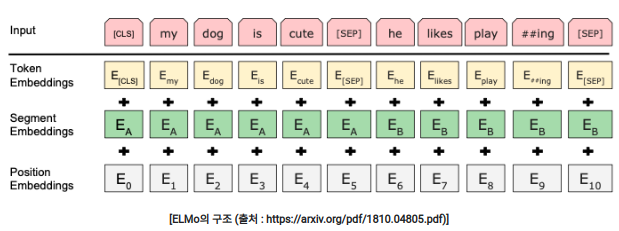

- 유틸리티 함수 정의

In [29]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    # tf.cast(): 텐서를 새로운 형태로 캐스팅함. 
    # tf.expand_dims() 배열의 차원을 늘려줌, axis는 몇 번째 차원 늘릴 것인가
    # tf.math.equal(): (x==y)의 진리값을 요소 단위로 반환
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)  
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)  # 같은 위치의 원소 중 더 큰 값을 출력
    return mask

- tf.linalg.band_part(input, num_lower, num_upper, name=None)    

Copy a tensor setting everything outside a central band in each innermost matrix to zero.   

(m-n) <= num_lower && (n-m) <= num_upper    
num_lower: 0-D 텐서. 유지할 부 대각선의 수. 음수이면 아래쪽 삼각형을 유지한다.    
num_upper: 0-D 텐서. 유지할 부 대각선의 수. 음수이면 위쪽 삼각형을 유지한다.


- GELU 함수

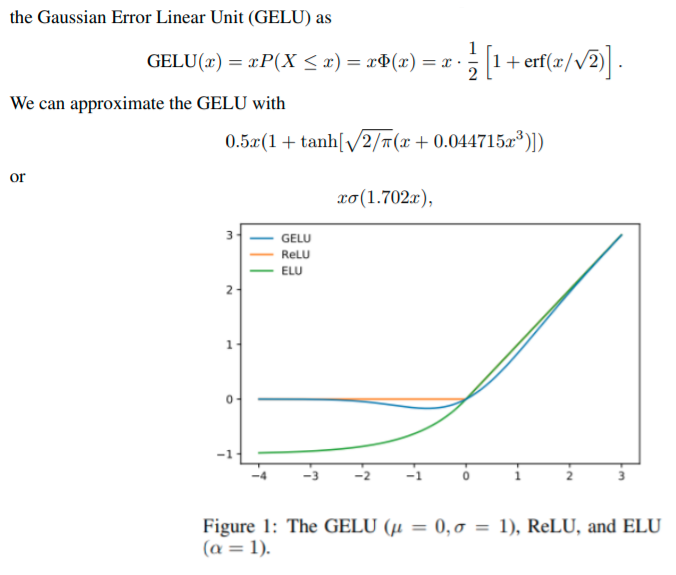


아래의 코드 구현은 위의 식 그대로이다.

```python
def gelu(x):
  cdf = 0.5 * (1.0 + tf.tanh(
      (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
  return x * cdf
```

그러나 아래의 코드는 위의 식을 계산 및 정리한 것을 구현한 것이다.

In [30]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))
print("슝=3")

슝=3


In [31]:
# 초기값 생성

def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    # 절단된 정규 분포에 따라 텐서를 생성하는 초기값 설정기
    # 정규 분포에서 생성된 값과 비슷하지만 평균으로부터 두 표준편차 이상 차이나는 값은 폐기 후 다시 뽑는다.
    # 신경망 가중치와 필터에 사용할 것이 권장된다.
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    # 모든 값이 0인 텐서를 생성하는 초기값 설정기
    return tf.zeros_initializer


데이터셋을 메모리에 로드한다. 

In [32]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__  # indexing
    __setattr__ = dict.__setitem__  # assigning to indexed values

    @classmethod  
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

class를 dictionary처럼 key, value를 할당(```__setitem__```)하고 사용(```__getitem__```)할 수 있게 해준다. 

- @classmethod    
정적메소드, 클래스에서 직접 접근할 수 있는 메소드. 인스턴스에서도 접근 가능. classmethod는 첫번째 인자로 클래스를 입력한다. 그러나 접근할 때는 첫번째 인자인 클래스를 생략하고 접근한다.  cls의 클래스속성을 가져온다.

In [33]:
# Embedding의 구현
# Token Embedding의 구현

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [34]:
# Positional Embedding 레이어
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [35]:
# ScaleDotProductAttention


class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [36]:
# MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [37]:
# transformer encoder 레이어

class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

- BERT 모델 구현

In [39]:
# BERT layer

class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

### 6. pretrain 진행


In [40]:
# pretrained BERT model

# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs
print("슝=3")

슝=3


In [41]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

- Config    
파라미터 설정 

In [42]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 8007,
 'i_pad': 0}

In [43]:
n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

loss나 accuracy같이 기본적으로 필요한 계산 함수를 미리 정의

In [44]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴
print("슝=3")

슝=3


- tf.math.not_equal()    
Returns the truth value of (x != y) element-wise.

In [45]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [46]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

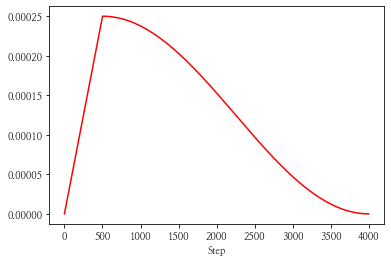

In [47]:
# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [48]:
# 모델 생성
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 4485632     enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

In [49]:
epochs = 10
batch_size = 64

# optimizer

# math.ceil(): Round a number upward to its nearest integer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [50]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
2000/2000 [==============================] - 207s 103ms/step - loss: 21.0206 - nsp_loss: 0.6670 - mlm_loss: 20.3535 - nsp_acc: 0.5631 - mlm_lm_acc: 0.1001

Epoch 00001: mlm_lm_acc improved from -inf to 0.10871, saving model to /home/aiffel-dj44/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 208s 104ms/step - loss: 17.7199 - nsp_loss: 0.6270 - mlm_loss: 17.0929 - nsp_acc: 0.6163 - mlm_lm_acc: 0.1286

Epoch 00002: mlm_lm_acc improved from 0.10871 to 0.12994, saving model to /home/aiffel-dj44/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 209s 104ms/step - loss: 16.4475 - nsp_loss: 0.6150 - mlm_loss: 15.8326 - nsp_acc: 0.6283 - mlm_lm_acc: 0.1421

Epoch 00003: mlm_lm_acc improved from 0.12994 to 0.15061, saving model to /home/aiffel-dj44/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 211s 106ms/step - loss: 14

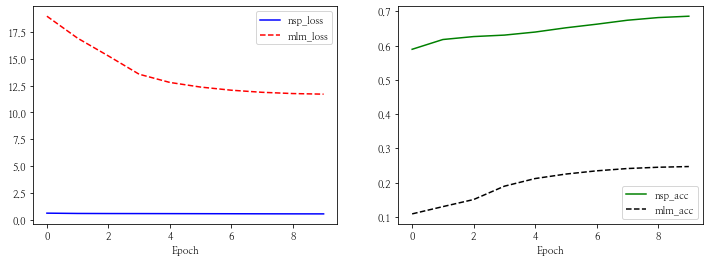

In [51]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 루브릭
|평가문항|	상세기준|결과|
|:------:|:--------:|:---:|
|1. 한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.|MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.|Y     |
|2. 구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.|학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.| Y  |
|3. 1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.|학습된 모델 및 학습과정의 시각화 내역이 제출되었다.| Y    |

## 후기
### 이번 프로젝트에서 어려웠던 점
- BERT의 개념
- 코드 구현

### 프로젝트를 진행하면서 알게된 점
- MLM, NSP
- BERT의 3가지 임베딩 종류

### 프로젝트를 진행하면서 아직 모호한 점
- 코드 구현 이해가 어렵다.

### 자기 다짐
Exploration에서도 다루었지만 여전히 BERT의 이해는 어렵다. 그래도 이론으로 배운 내용을 코드를 통해 직관적으로 이해할 수 있었다. 완벽한 이해는 어렵지만 어떻게 BERT가 구성되고 어떤 Task를 할 수 있는지 등을 알 수 있었다. 해커톤3에서 BERT를 이용하는데, 이번 프로젝트가 도움이 되었으면 한다.  